# 🌬️ Pearls AQI Predictor: Exploratory Data Analysis (EDA)

### 1. IMPORTS

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta

# Set plot style for better visuals
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 2. FETCH STANDALONE DATA (Safely handling Open-Meteo Archive Lag)

In [10]:
print("Fetching 1 year of historical data for Karachi...")
LAT, LON = 24.8607, 67.0011

# End date must be 7 days ago, as the archive API takes a week to process new data
end_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=372)).strftime('%Y-%m-%d')

w_url = f"https://archive-api.open-meteo.com/v1/archive?latitude={LAT}&longitude={LON}&start_date={start_date}&end_date={end_date}&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m&timezone=Asia%2FKarachi"
aq_url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude={LAT}&longitude={LON}&start_date={start_date}&end_date={end_date}&hourly=pm10,pm2_5,nitrogen_dioxide,ozone&timezone=Asia%2FKarachi"

w_response = requests.get(w_url)
aq_response = requests.get(aq_url)

w_data = w_response.json()
aq_data = aq_response.json()

# Safety check
if 'hourly' not in w_data or 'hourly' not in aq_data:
    raise ValueError(f"API Error.\nWeather API Response: {w_data}\nAQI API Response: {aq_data}")

# Build DataFrame
df = pd.DataFrame({
    'timestamp': pd.to_datetime(w_data['hourly']['time']),
    'temp': w_data['hourly']['temperature_2m'],
    'humidity': w_data['hourly']['relative_humidity_2m'],
    'wind_speed': w_data['hourly']['wind_speed_10m'],
    'pm25': aq_data['hourly']['pm2_5'],
    'pm10': aq_data['hourly']['pm10'],
    'no2': aq_data['hourly']['nitrogen_dioxide'],
    'o3': aq_data['hourly']['ozone']
}).dropna()

df.set_index('timestamp', inplace=True)
print(f"✅ Data fetched successfully! Shape: {df.shape}")

Fetching 1 year of historical data for Karachi...
✅ Data fetched successfully! Shape: (8784, 7)


### 3. HELPER FUNCTION: Calculate AQI

In [11]:
def compute_aqi_from_pm25(pm25):
    if pd.isna(pm25): return 0
    if pm25 <= 12: return 50 * (pm25 / 12)
    elif pm25 <= 35.4: return 50 + (50 * (pm25 - 12) / (35.4 - 12))
    elif pm25 <= 55.4: return 100 + (50 * (pm25 - 35.4) / (55.4 - 35.4))
    else: return 150 + (100 * (pm25 - 55.4) / 100.0)

df['aqi'] = df['pm25'].apply(compute_aqi_from_pm25)

## Part 1: Distribution of Air Quality (PM2.5)

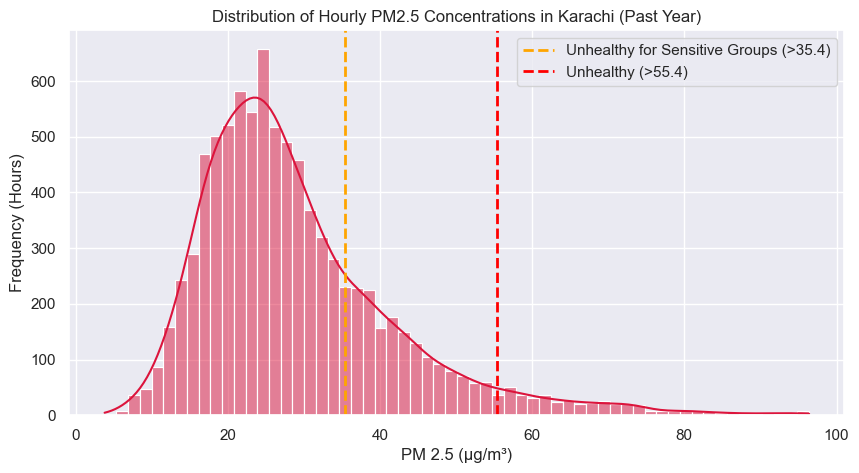

In [12]:
# How often is the air quality hazardous in Karachi?
plt.figure(figsize=(10, 5))
sns.histplot(df['pm25'], bins=60, kde=True, color='crimson')
plt.axvline(x=35.4, color='orange', linestyle='--', linewidth=2, label='Unhealthy for Sensitive Groups (>35.4)')
plt.axvline(x=55.4, color='red', linestyle='--', linewidth=2, label='Unhealthy (>55.4)')
plt.title('Distribution of Hourly PM2.5 Concentrations in Karachi (Past Year)')
plt.xlabel('PM 2.5 (µg/m³)')
plt.ylabel('Frequency (Hours)')
plt.legend()
plt.show()

## Part 2: Feature Correlation

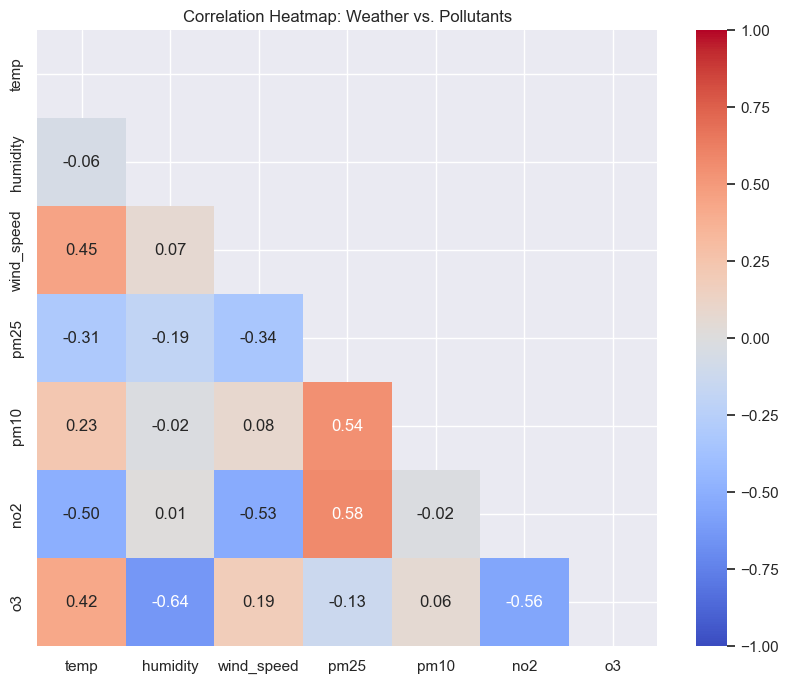

In [13]:
# Which meteorological factors (weather) correlate most with pollution?

plt.figure(figsize=(10, 8))
corr_matrix = df[['temp', 'humidity', 'wind_speed', 'pm25', 'pm10', 'no2', 'o3']].corr()

# Use a mask to hide the upper triangle for a cleaner look
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Weather vs. Pollutants')
plt.show()

**Insight:** We typically expect negative correlation between `wind_speed` and `pm25` (wind blows smog away), and sometimes negative correlation with `temp` (winter inversions trap cold, dirty air near the surface).

## Part 3: Seasonality and Time Trends

C:\Users\Muhammad Akbar\AppData\Local\Temp\ipykernel_16732\1274504216.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='month', y='pm25', ax=axes[1], palette='viridis')


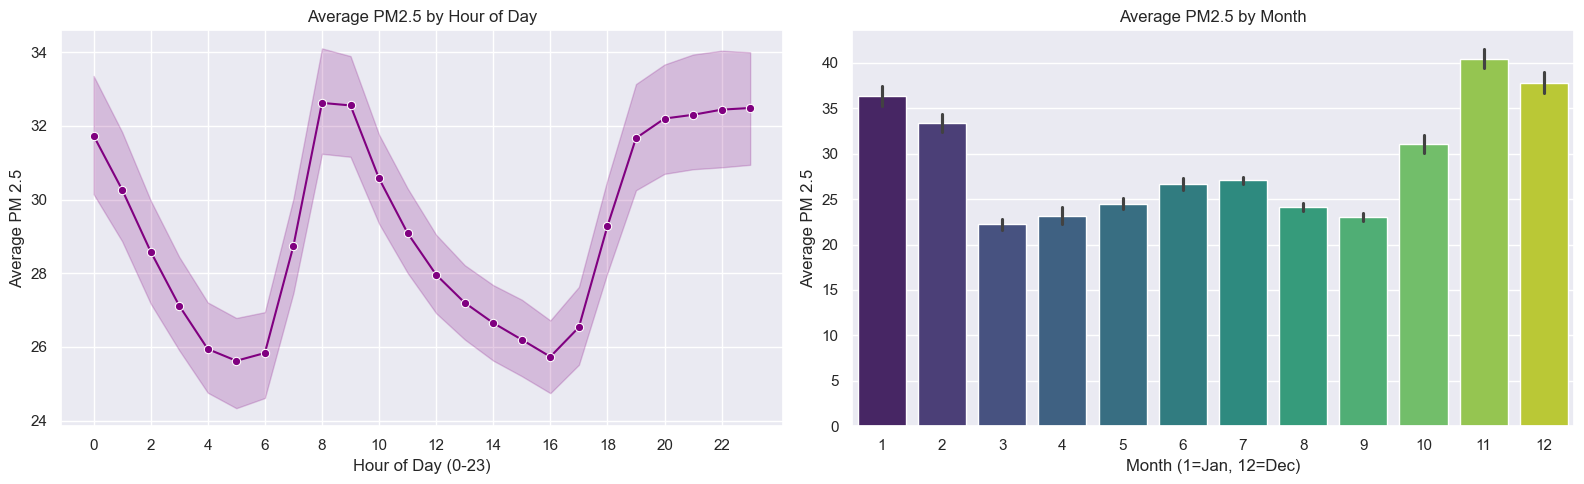

In [14]:
# Does pollution get worse at certain times of the day or year?

# Extract time features
df['hour'] = df.index.hour
df['month'] = df.index.month

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Daily Cycle
sns.lineplot(data=df, x='hour', y='pm25', ax=axes[0], color='purple', marker='o')
axes[0].set_title('Average PM2.5 by Hour of Day')
axes[0].set_xlabel('Hour of Day (0-23)')
axes[0].set_ylabel('Average PM 2.5')
axes[0].set_xticks(range(0, 24, 2))

# Plot 2: Yearly Cycle
sns.barplot(data=df, x='month', y='pm25', ax=axes[1], palette='viridis')
axes[1].set_title('Average PM2.5 by Month')
axes[1].set_xlabel('Month (1=Jan, 12=Dec)')
axes[1].set_ylabel('Average PM 2.5')

plt.tight_layout()
plt.show()

**Insight:**
1. **Hourly:** Pollution often spikes in the morning/evening due to rush hour traffic and atmospheric cooling. 
2. **Monthly:** Winter months (Nov-Jan) usually show significantly higher AQI due to temperature inversions trapping pollutants.

## Part 4: The Impact of Wind Speed

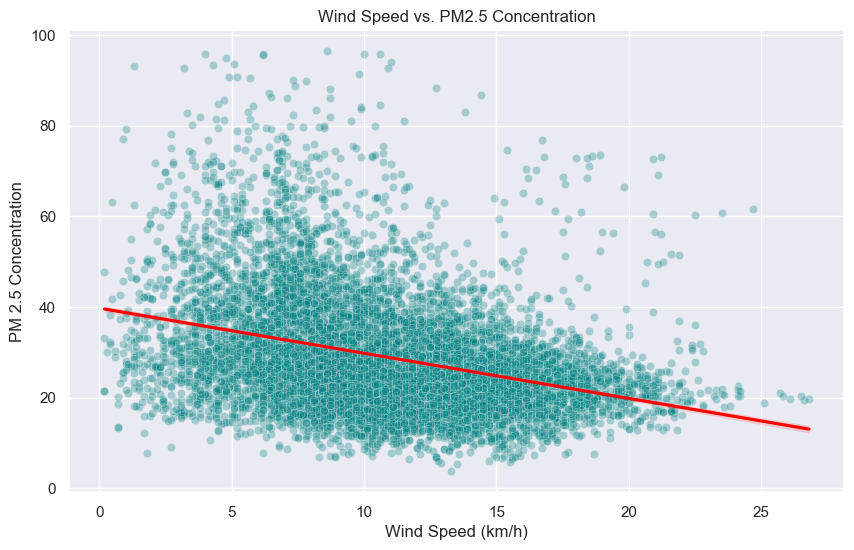

In [15]:
# Visualizing how higher wind speeds physically disperse PM2.5.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='wind_speed', y='pm25', alpha=0.3, color='teal')
sns.regplot(data=df, x='wind_speed', y='pm25', scatter=False, color='red')
plt.title('Wind Speed vs. PM2.5 Concentration')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('PM 2.5 Concentration')
plt.show()